In [1]:
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import transpile
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
import qiskit
import math

In [2]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

In [3]:
def XOR(qc,a,b,output):
    qc.cx(a,output)
    qc.cx(b,output)

In [4]:
def sudoku_oracle(qc, clause_list, var_qubits, clause_qubits,output_qubit):
    # does above operations for all the pairs. final state is 1 iff it is a solution
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    # Create a MultiControlledX gate
    mcx_gate = qc.mcx(clause_qubits,output_qubit)

    # Append the gate to the circuit
    # qc.append(mcx_gate, clause_qubits[:] + [output_qubit])

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1


In [5]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Do multi-controlled-Z gate
    qc.h(nqubits - 1)
    qc.mcx(list(range(nqubits - 1)), nqubits - 1)  # multi-controlled-Toffoli
    qc.h(nqubits - 1)
    
    # Apply transformation |11..1> -> |00..0> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U$"
    return U_s


Implementation of Quantum phase estimation

In [6]:
def grover_operator(clause_list, var_qubits, clause_qubits, output_qubit):
    # Create Grover operator as a gate
    qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)
    
    # Oracle
    sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, output_qubit)
    
    # Diffuser (only on var_qubits)
    diff = diffuser(len(var_qubits))
    qc.append(diff, var_qubits[:])
    
    # Convert to gate
    grover_gate = qc.to_gate()
    grover_gate.name = "Grover"
    return grover_gate

def qpe_with_grover(clause_list, precision_qubits):
    # Create registers
    t = precision_qubits  # number of precision qubits
    var_qubits = QuantumRegister(4, name='v')
    clause_qubits = QuantumRegister(4, name='c')
    output_qubit = QuantumRegister(1, name='out')
    phase_qubits = QuantumRegister(t, 'phase')
    cbits = ClassicalRegister(t, 'cbits')
    
    # Create circuit
    qc = QuantumCircuit(phase_qubits, var_qubits, clause_qubits, output_qubit, cbits)
    
    # Initialize var_qubits in superposition
    for qubit in var_qubits:
        qc.h(qubit)
    
    # Initialize phase estimation qubits
    for qubit in phase_qubits:
        qc.h(qubit)
    for qubit in output_qubit:
        qc.x(qubit)
        qc.h(qubit)
    # Create Grover operator
    grover = grover_operator(clause_list, var_qubits, clause_qubits, output_qubit)
    # Controlled Grover operations
    for i in range(t-1,-1,-1):
        # Apply 2^i controlled Grover operations
        # print(i)
        index = t-i-1
        for j in range(2**index):
            c_q = grover.control()
            qc.append(c_q, [phase_qubits[i]] + var_qubits[:] + clause_qubits[:] + output_qubit[:])
    # print(qc.draw("mpl"))
    qc.append(QFT(t).inverse(), phase_qubits)

    # Measure phase qubits
    qc.barrier()
    qc.measure(phase_qubits, cbits)
    
    return qc

In [21]:
#finding qubits in first register case 2
n = 4
e = 0.05  #error probability
t = math.ceil(n + np.log2(2+1/(2*e)))
print("Precision qubits: ", t)

Precision qubits:  8


In [22]:
# Example usage

precision_qubits = t  # Number of qubits for phase estimation
qc = qpe_with_grover(clause_list, precision_qubits)


In [23]:
from qiskit_aer import AerSimulator
backend = AerSimulator()

qc_transpiled = transpile(qc, backend, optimization_level=1)



# Execute the transpiled circuit on the real quantum device
job = backend.run(qc_transpiled, shots=1024)


result = job.result()
counts = result.get_counts()
print(counts)

{'00010101': 1, '01010111': 1, '10100110': 1, '01111001': 1, '01111111': 2, '10000110': 1, '00011010': 1, '01001111': 22, '10011001': 3, '10110100': 9, '00011110': 1, '01111110': 1, '11000101': 1, '11111011': 1, '11010011': 1, '11100100': 1, '10101100': 1, '01011100': 1, '11101011': 1, '01111100': 2, '00011001': 2, '00101111': 1, '10101001': 1, '01001100': 5, '11011110': 2, '10011111': 2, '01000010': 3, '11001101': 1, '01100110': 2, '01101111': 2, '11100101': 1, '01001110': 3, '01011001': 1, '11100001': 5, '10010010': 2, '11010101': 2, '01100100': 10, '00100011': 22, '10100100': 1, '11000010': 3, '01100001': 2, '00100001': 3, '01011101': 7, '00100010': 2, '10110101': 20, '10111110': 2, '11110011': 1, '11011011': 1, '00100100': 3, '00100110': 1, '10110010': 4, '10100011': 6, '10111100': 12, '00011100': 2, '00000011': 8, '00100101': 1, '01011011': 9, '00000001': 2, '01100111': 5, '00101011': 3, '10011100': 12, '01000111': 9, '10111010': 3, '01100011': 117, '10100010': 6, '00111111': 10, 

In [24]:
counts1 = result.get_counts(qc)
print(counts1)

# Gets the most frequent value from counts1, which is the j that QPE returns
freq = qiskit.result.Counts.most_frequent(counts1)
qpe_result = int(freq,2)
qpe_result = int(freq,2)
print("phase: ",qpe_result) #finding j

{'00010101': 1, '01010111': 1, '10100110': 1, '01111001': 1, '01111111': 2, '10000110': 1, '00011010': 1, '01001111': 22, '10011001': 3, '10110100': 9, '00011110': 1, '01111110': 1, '11000101': 1, '11111011': 1, '11010011': 1, '11100100': 1, '10101100': 1, '01011100': 1, '11101011': 1, '01111100': 2, '00011001': 2, '00101111': 1, '10101001': 1, '01001100': 5, '11011110': 2, '10011111': 2, '01000010': 3, '11001101': 1, '01100110': 2, '01101111': 2, '11100101': 1, '01001110': 3, '01011001': 1, '11100001': 5, '10010010': 2, '11010101': 2, '01100100': 10, '00100011': 22, '10100100': 1, '11000010': 3, '01100001': 2, '00100001': 3, '01011101': 7, '00100010': 2, '10110101': 20, '10111110': 2, '11110011': 1, '11011011': 1, '00100100': 3, '00100110': 1, '10110010': 4, '10100011': 6, '10111100': 12, '00011100': 2, '00000011': 8, '00100101': 1, '01011011': 9, '00000001': 2, '01100111': 5, '00101011': 3, '10011100': 12, '01000111': 9, '10111010': 3, '01100011': 117, '10100010': 6, '00111111': 10, 

In [16]:
# finding the number of solutions
#m = 2**4*(math.sin(math.pi*qpe_result/(2**precision_qubits) - math.pi/2))**2

m = math.ceil(2**n*(math.sin(math.pi*qpe_result/(2**precision_qubits) - math.pi/2))**2)
print("Number of solutions:", m)   

Number of solutions: 2


Solving sudokku knowing M = 2

In [17]:
# finding the number of iterations as we know the solution
N = 2**4
M = m
k = math.floor(math.pi/4*math.sqrt(N/M))
print("Number of iterations:", k)  

Number of iterations: 2


In [18]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')

qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialise 'out0' in state |->⟩
qc.x( output_qubit)
qc.h( output_qubit)
# qc.initialize([1, -1] / np.sqrt(2), output_qubit)
# Initialise qubits in state |s⟩
qc.h(var_qubits)
qc.barrier()  # for visual separation

## Iteration depending on k
# Apply our oracle
for i in range(k):
    sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, output_qubit)
    qc.barrier()  # for visual separation
    # Apply our diffuser
    qc.append(diffuser(4), [0, 1, 2, 3])



# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw()


┌───┐      ░                                                        »
    v_0: ┤ H ├──────░───■─────────■──────────────────────────────────■───────»
         ├───┤      ░   │         │                                  │       »
    v_1: ┤ H ├──────░───┼────■────┼─────────■────────────────────────┼────■──»
         ├───┤      ░   │    │    │         │                        │    │  »
    v_2: ┤ H ├──────░───┼────┼────┼────■────┼─────────■──────────────┼────┼──»
         ├───┤      ░   │    │    │    │    │         │              │    │  »
    v_3: ┤ H ├──────░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼──»
         └───┘      ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐»
    c_0: ───────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├»
                    ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘»
    c_1: ───────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────»
                    ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            »
    c_2: ───────────░─────────────────────┤ X ├┤ X ├──┼────┼────■────────────»
                    ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │            »
    c_3: ───────────░───────────────────────────────┤ X ├┤ X ├──■────────────»
         ┌───┐┌───┐ ░                               └───┘└───┘┌─┴─┐          »
    out: ┤ X ├┤ H ├─░─────────────────────────────────────────┤ X ├──────────»
         └───┘└───┘ ░                                         └───┘          »
cbits: 4/════════════════════════════════════════════════════════════════════»
                                                                             »
«                                        ░ ┌──────┐                         »
«    v_0: ──■────────────────────────────░─┤0     ├──■─────────■────────────»
«           │                            ░ │      │  │         │            »
«    v_1: ──┼─────────■──────────────────░─┤1     ├──┼────■────┼─────────■──»
«           │         │                  ░ │  $U$ │  │    │    │         │  »
«    v_2: ──┼────■────┼─────────■────────░─┤2     ├──┼────┼────┼────■────┼──»
«           │    │    │         │        ░ │      │  │    │    │    │    │  »
«    v_3: ──┼────┼────┼────■────┼────■───░─┤3     ├──┼────┼────┼────┼────┼──»
«           │    │    │    │    │    │   ░ └──────┘┌─┴─┐┌─┴─┐  │    │    │  »
«    c_0: ──┼────┼────┼────┼────┼────┼───░─────────┤ X ├┤ X ├──┼────┼────┼──»
«         ┌─┴─┐┌─┴─┐  │    │    │    │   ░         └───┘└───┘┌─┴─┐┌─┴─┐  │  »
«    c_1: ┤ X ├┤ X ├──┼────┼────┼────┼───░───────────────────┤ X ├┤ X ├──┼──»
«         └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░                   └───┘└───┘┌─┴─┐»
«    c_2: ──────────┤ X ├┤ X ├──┼────┼───░─────────────────────────────┤ X ├»
«                   └───┘└───┘┌─┴─┐┌─┴─┐ ░                             └───┘»
«    c_3: ────────────────────┤ X ├┤ X ├─░──────────────────────────────────»
«                             └───┘└───┘ ░                                  »
«    out: ───────────────────────────────░──────────────────────────────────»
«                                        ░                                  »
«cbits: 4/══════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                      ░ »
«    v_0: ──────────────────────■─────────■────────────────────────────░─»
«                               │         │                            ░ »
«    v_1: ──────────────────────┼────■────┼─────────■──────────────────░─»
«                               │    │    │         │                  ░ »
«    v_2: ───────■──────────────┼────┼────┼────■────┼─────────■────────░─»
«                │              │    │    │    │    │         │        ░ »
«    v_3: ──■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─»
«           │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ »
«    c_0: ──┼────┼────┼────■──┤ X ├┤ 

In [19]:
from qiskit_aer import AerSimulator
backend = AerSimulator()

qc_transpiled = transpile(qc, backend, optimization_level=1)



# Execute the transpiled circuit on the real quantum device
job = backend.run(qc_transpiled, shots=1024)


result = job.result()
counts = result.get_counts()
counts

{'1110': 2,
 '1011': 2,
 '0011': 1,
 '0001': 2,
 '1111': 8,
 '1101': 3,
 '0010': 5,
 '0000': 2,
 '1000': 8,
 '1010': 4,
 '0111': 6,
 '1001': 479,
 '0101': 4,
 '1100': 4,
 '0100': 11,
 '0110': 483}

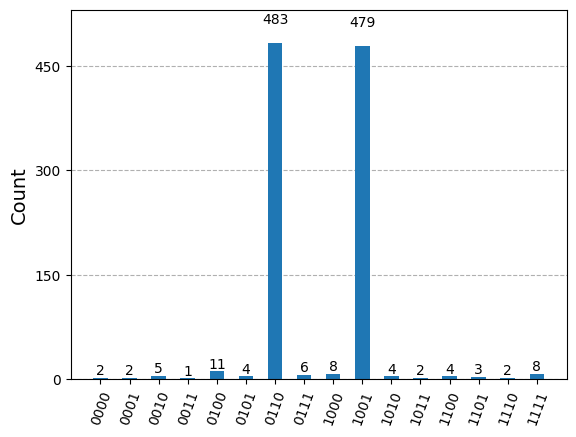

In [20]:
# Plot the histogram of counts
plot_histogram(counts)
